***Functions***

In [39]:
#import sys
#sys.path.append("https://github.com/Quan-Zhou/OT_Debiasing")  
#from functions import*

In [40]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

***Assumptions***

**S**
* t=1/2-Pr[f]=Pr[m]-1/2

**S=f**
* U: $B(0.2)$, Pr[a|f]=0.2
* X|U=a: $N(-10,25)$
* X|U=b: $N(-12,25)$

**S=m**
* U: $B(0.8)$, Pr[a|m]=0.8
* X|U=a: $N(12,1)$
* X|U=b: $N(10,1)$

***Definitions***

* **para:** all parameters based on assumptions

* **dist:** all distributions based on assumptions, including target distributions

In [2]:
keys = ['t','a_f', 'a_m','b_f', 'b_m']
values = [0.2,0.2,0.8,0.8,0.2]
para = dict(zip(keys, values))
para['X_af_mean']=-10
para['X_af_sd']=5
para['X_bf_mean']=-12
para['X_bf_sd']=5
para['X_am_mean']=12
para['X_am_sd']=1
para['X_bm_mean']=10
para['X_bm_sd']=1
para['f']=1/2-para['t']
para['m']=1/2+para['t']
para['a']=para['a_f']*para['f']+para['a_m']*para['m']
para['b']=para['b_f']*para['f']+para['b_m']*para['m']
para['af']=para['a_f']*para['f']
para['bf']=para['b_f']*para['f']
para['am']=para['a_m']*para['m']
para['bm']=para['b_m']*para['m']
para['f_a']=para['af']/para['a'] #inverse_probability('f_a',para)
para['m_a']=para['am']/para['a'] #inverse_probability('m_a',para)
para['f_b']=para['bf']/para['b'] #=inverse_probability('f_b',para)
para['m_b']=para['bm']/para['b'] #inverse_probability('m_b',para)


In [3]:
horizen=[-50,50]
width=0.1
bin=int((horizen[1]-horizen[0])/width)
x_range=np.arange(horizen[0],horizen[1],width)
dist = dict(zip(['horizen','width','bin','x_range'], [horizen,width,bin,x_range]))
dist['x_af']=[Gaussian_pdf(x,'X_af',para)*width for x in x_range]
dist['x_am']=[Gaussian_pdf(x,'X_am',para)*width for x in x_range]
dist['x_bf']=[Gaussian_pdf(x,'X_bf',para)*width for x in x_range]
dist['x_bm']=[Gaussian_pdf(x,'X_bm',para)*width for x in x_range]
dist['x_a']=[dist['x_af'][i]*para['a_f']+dist['x_am'][i]*para['a_m'] for i in range(bin)]
dist['x_b']=[dist['x_bf'][i]*para['b_f']+dist['x_bm'][i]*para['b_m'] for i in range(bin)]
dist['t_x_a']=normialise([dist['x_af'][i]**para['f_a']*dist['x_am'][i]**para['m_a'] for i in range(bin)])  
dist['t_x_b']=normialise([dist['x_bf'][i]**para['f_b']*dist['x_bm'][i]**para['m_b'] for i in range(bin)]) 

***OT algorithms***

* **output:** couplings for U=a and U=b

top:x_a
right:target_x_a
sum of violation of f: 1.2489301067286307e-16
sum of violation of g: 1.4632915954095252e-14
total cost: 47.82075405769424
entropy: 6.437227211339468
top:x_b
right:target_x_b
sum of violation of f: 1.4382677739550665e-16
sum of violation of g: 2.4627157591736504e-14
total cost: 163.1184828186573
entropy: 6.80622444500094


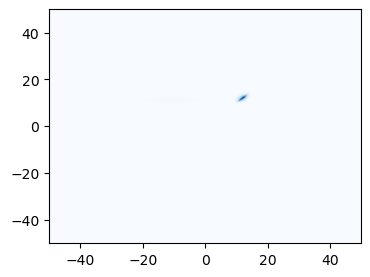

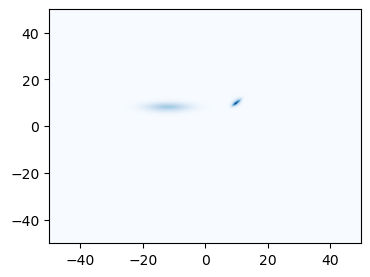

In [4]:
U_range=['a','b']
output=dict(key=U_range)
reg=0.01 #10**(1-2)
for u in U_range:
    print('top:x_'+u)
    print('right:target_x_'+u)
    mu=np.array(dist['x_'+u])
    mu_t=np.array(dist['t_x_'+u])
    output[u]=OT(reg,x_range,mu,mu_t)

***Data generation and projection***

* **data:** generated random data
* **data_revised:** data projected by couplings
* **dist_source:** all empiricial distributions of data
* **dist_project:** all empiricial distributions of data_revised

In [5]:
num=10000
data=samples_groupby(data_generation(num,para))
data_revised=pd.concat([projection(data[data['U']==u],output[u]) for u in U_range],ignore_index=True)
name_list=['af','bf','am','bm']
dist_source=dict()
dist_project=dict() #dict(keys=['x_'+i for i in name_list])
for name in name_list:
    dist_source['x_'+name]=empirical_distribution(data[(data['U']==name[0])&(data['S']==name[1])],dist)
    dist_project['x_'+name]=empirical_distribution(data_revised[(data_revised['U']==name[0])&(data_revised['S']==name[1])],dist)

Text(0.5, 1.0, 'source data distribution')

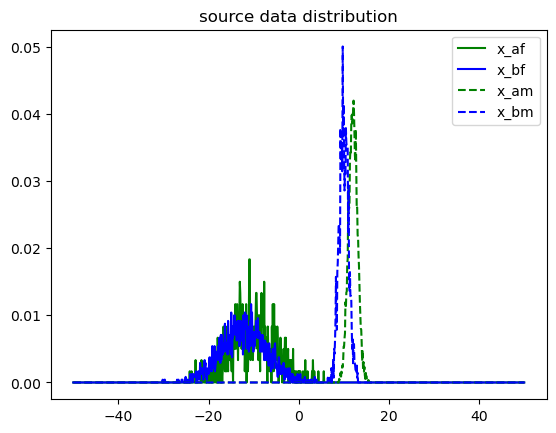

In [26]:
for key,value in dist_source.items():
    linestyle=str('g' if key[-2]=='a' else 'b')+str('-' if key[-1]=='f' else '--')
    plt.plot(x_range,value,linestyle,label=key)
plt.legend()
plt.title('source data distribution')

Text(0.5, 1.0, 'projected data distribution')

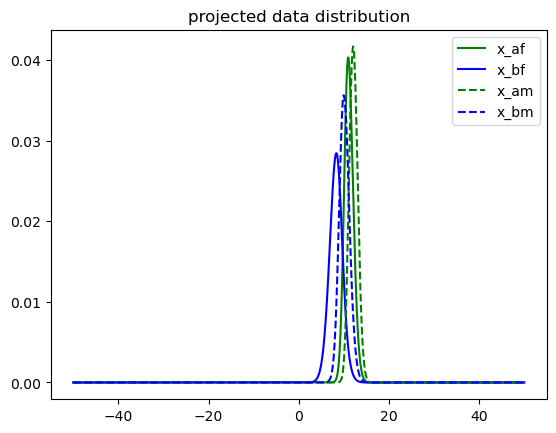

In [28]:
for key,value in dist_project.items():
    linestyle=str('g' if key[-2]=='a' else 'b')+str('-' if key[-1]=='f' else '--')
    plt.plot(x_range,value,linestyle,label=key)
plt.legend()
plt.title('projected data distribution')

***Problems***

In [8]:
para['X_a_t_mean']=para['X_af_mean']*para['f_a']+para['X_am_mean']*para['m_a']
para['X_a_t_sd']=math.sqrt(second_moment('X_af',para)*para['f_a']+second_moment('X_am',para)*para['m_a']-para['X_a_t_mean']**2)
dist['t_x_a']=[Gaussian_pdf(x,'X_a_t',para)*width for x in x_range]
dist['t_x_b']=[Gaussian_pdf(x,'X_b_t',para)*width for x in x_range]

KeyError: 'X_b_t_mean'